# Main Quest 01 : GPT 모델 구현하기

- 아래는 LMS 노드 '10. 트랜스포머로 만드는 대화형 챗봇' 내용을 Quest 요구사항에 맞게 변경한 코드입니다.
- 아키텍처상 변경 사항은 아래 사진으로 설명하고 해당 내용을 주석처리 하였습니다.
- 변경한 부분은 '수정' 이라는 키워드를 포함하여 주석처리했습니다.
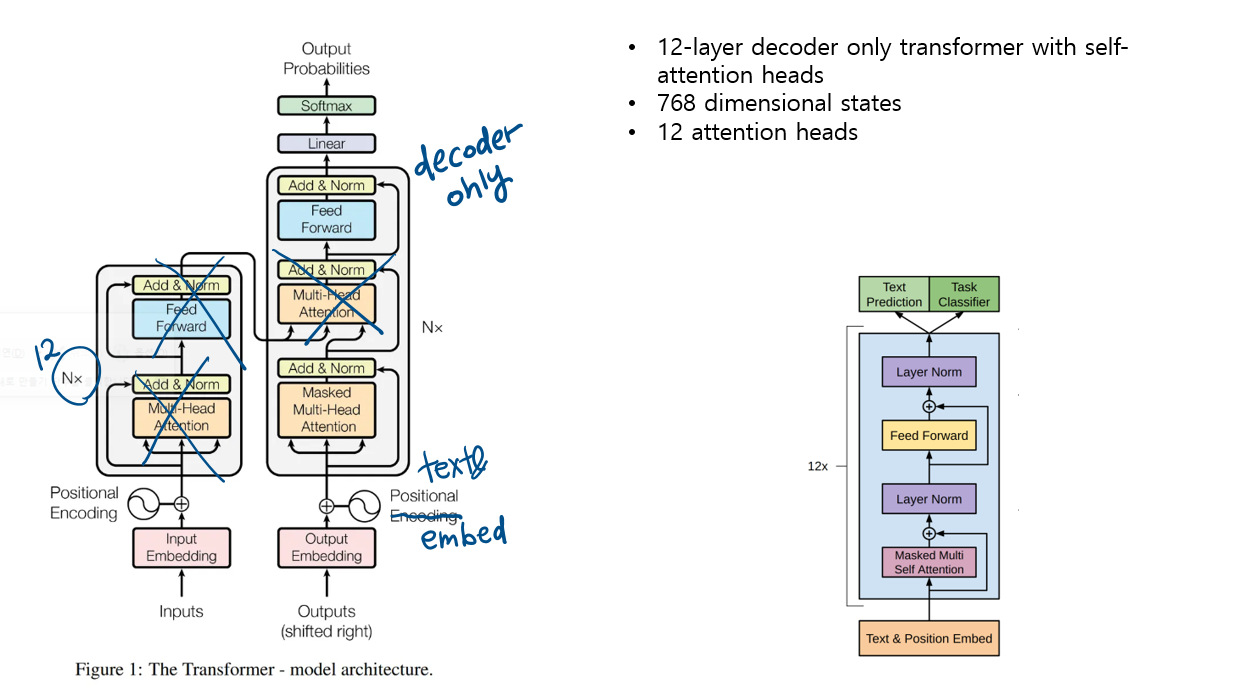

# 10. 트랜스포머로 만드는 대화형 챗봇

- 평가기준
1. 한국어 전처리를 통해 학습 데이터셋 구축
: 공백, 특수문자처리, 토크나이징, 병렬 데이터 구축
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습 정상적 진행
: 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적 수렴
3. 한국어 입력 문장에 대해 한국어로 대답하는 함수 구현
: 한국어 입력 문장 맥락에 맞는 한국어로 답변 리턴

#### 라이브러리 import

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import csv
import numpy as np
import matplotlib.pyplot as plt

## Step 1. 데이터 수집하기

- cloud shell을 통한 다운로드를 진행함. 
- 데이터 출처 : https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

In [2]:
# CSV 파일을 다운로드하고 압축 해제
path_to_csv = tf.keras.utils.get_file(
    'ChatbotData.csv', 
    origin='https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv')

# Step 2. 데이터 전처리하기
- 한글 질의응답 데이터로 다음과 같은 flow로 전처리를 진행해야 한다.
- 질문을 premise, 답변을 hypothesis로 취급하여 작성
수정
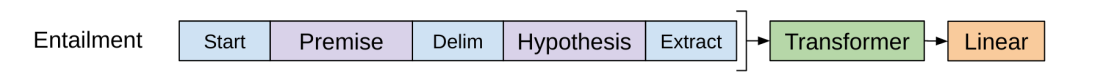

In [3]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 3000
print(MAX_SAMPLES)

3000


### 한글 전처리를 위한 함수 변경
- 영문 전처리에서 사용하던 소문자화 부분을 제외함. 공백 제거만 사용.
- 구두점 사이 거리를 만드는 코드 그대로 사용
- 구두점 제외 문자열 추출 과정에서 한국어 포함

In [4]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 공백 제거
    sentence = sentence.strip()
    
    # 구두점과 단어 사이의 거리를 만듦
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 구두점 제외 문자열 추출 (한국어, 영어, 숫자만 남김)
    sentence = re.sub("[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    # 연속된 ㅋ, ㅎ, ㅠ 정규화 - 승환님 참고 
    sentence = re.sub(r'ㅋ{2,}', 'ㅋㅋ', sentence)
    sentence = re.sub(r'ㅎ{2,}', 'ㅎㅎ', sentence)
    sentence = re.sub(r'ㅠ{2,}', 'ㅠㅠ', sentence)
    return sentence

In [5]:
# 질문과 답변 데이터를 로드하고 전처리하는 함수
def load_conversations():
    inputs, outputs = [], []
    
    # CSV 파일 열기
    with open(path_to_csv, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # 첫 번째 줄(헤더)을 건너뜀
        
        for row in reader:
            # 각 행에서 질문과 답변을 추출
            question, answer = row[0], row[1]
            
            # 전처리 함수를 질문과 답변에 적용
            inputs.append(preprocess_sentence(question))
            outputs.append(preprocess_sentence(answer))
            
            # 최대 샘플 수만큼 데이터를 가져옴
            if len(inputs) >= MAX_SAMPLES:
                break

    return inputs, outputs

In [6]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 3000
전체 샘플 수 : 3000


In [7]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## Step3. SubwordTextEncoder 사용하기

In [8]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [9]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [10]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [6651]
END_TOKEN의 번호 : [6652]


In [11]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

6653


In [12]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [1483, 1131, 2156]
정수 인코딩 후의 21번째 답변 샘플: [546, 2962, 16, 1840, 1]


In [13]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 25
print(MAX_LENGTH)

25


In [14]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [15]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 6653
필터링 후의 질문 샘플 개수: 3000
필터링 후의 답변 샘플 개수: 3000


In [16]:
BATCH_SIZE = 128
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions, 
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## Step 4. 모델 구성하기

In [17]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs") 
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  '''
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  '''

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  '''
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])
  '''

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [18]:
# 포지셔널 임베딩 레이어 수정

class PositionalEmbedding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEmbedding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")


슝=3


- scaled dot product attention

In [19]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


- multihead attention

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


- look ahead mask 사용

In [21]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [22]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


- encoder 사용

In [23]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
'''
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")
'''

'\ndef encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):\n  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")\n\n  # 패딩 마스크 사용\n  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")\n\n  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)\n  attention = MultiHeadAttention(\n      d_model, num_heads, name="attention")({\n          \'query\': inputs,\n          \'key\': inputs,\n          \'value\': inputs,\n          \'mask\': padding_mask\n      })\n\n  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행\n  attention = tf.keras.layers.Dropout(rate=dropout)(attention)\n  attention = tf.keras.layers.LayerNormalization(\n      epsilon=1e-6)(inputs + attention)\n\n  # 두 번째 서브 레이어 : 2개의 완전연결층\n  outputs = tf.keras.layers.Dense(units=units, activation=\'relu\')(attention)\n  outputs = tf.keras.layers.Dense(units=d_model)(outputs)\n\n  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행\n  outputs = tf.keras.layers.Dropout(rate=dropout)(out

In [24]:
'''
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")
'''

'\ndef encoder(vocab_size,\n            num_layers,\n            units,\n            d_model,\n            num_heads,\n            dropout,\n            name="encoder"):\n  inputs = tf.keras.Input(shape=(None,), name="inputs")\n\n  # 패딩 마스크 사용\n  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")\n\n  # 임베딩 레이어\n  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)\n  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))\n\n  # 포지셔널 인코딩\n  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)\n\n  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)\n\n  # num_layers만큼 쌓아올린 인코더의 층.\n  for i in range(num_layers):\n    outputs = encoder_layer(\n        units=units,\n        d_model=d_model,\n        num_heads=num_heads,\n        dropout=dropout,\n        name="encoder_layer_{}".format(i),\n    )([outputs, padding_mask])\n\n  return tf.keras.Model(\n      inputs=[inputs, padding_mask], outputs=outputs, name=name)\nprint("슝=3")\n'

- decoder 사용

In [25]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  #enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs") #enc output을 받지 않음 수정
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션) 주석 수정
  '''
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  '''
    
  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention1) #수정 atttention 1 받음
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1) # 수정 atttention 1
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1) #수정 attention 1

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask, padding_mask], #수정 enc_outputs parameter 제거
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [26]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  #enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEmbedding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, look_ahead_mask, padding_mask]) # 수정 enc_outpus

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask, padding_mask], #수정 enc ouputs
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### 모델 생성
- GPT1 모델과 같이 decoder만을 사용하고, 12개의 layer를 사용하도록 수정함
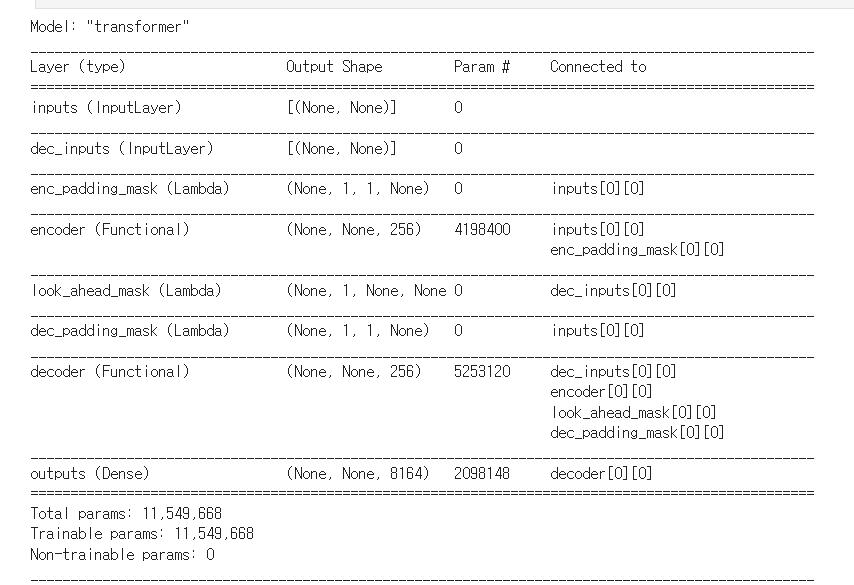

In [27]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 12 # 디코더의 층의 개수 # 12개로 수정
D_MODEL = 256 # 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.08 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
dec_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
________________________________________________________________________________________

## pretrain 모델 컴파일 및 학습
- gpt1에 맞게 수정된 내용

In [28]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0005)

model.compile(optimizer=optimizer,
             loss=tf.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

train_dataset = tf.data.Dataset.from_tensor_slices(((questions, answers), answers))
train_dataset = train_dataset.batch(BATCH_SIZE)


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(train_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50
24/24 [==============================] - 19s 119ms/step - loss: 4.1626 - accuracy: 0.7164
Epoch 2/50
24/24 [==============================] - 3s 118ms/step - loss: 3.4224 - accuracy: 0.7476
Epoch 3/50
24/24 [==============================] - 3s 118ms/step - loss: 3.4914 - accuracy: 0.7476
Epoch 4/50
24/24 [==============================] - 3s 119ms/step - loss: 3.4539 - accuracy: 0.7476
Epoch 5/50
24/24 [==============================] - 3s 119ms/step - loss: 3.4745 - accuracy: 0.7476


### 손실 함수

In [37]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


### 커스텀된 학습률

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

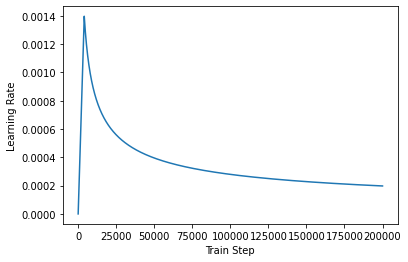

In [31]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 컴파일

In [32]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


### 훈련하기


In [55]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(dataset, epochs=200, batch_size=32, callbacks=[early_stopping])

Epoch 1/200
24/24 [==============================] - 14s 103ms/step - loss: 0.6877 - accuracy: 0.1034
Epoch 2/200
24/24 [==============================] - 2s 102ms/step - loss: 0.6766 - accuracy: 0.1040
Epoch 3/200
24/24 [==============================] - 2s 102ms/step - loss: 0.6681 - accuracy: 0.1050
Epoch 4/200
24/24 [==============================] - 2s 102ms/step - loss: 0.6527 - accuracy: 0.1067
Epoch 5/200
24/24 [==============================] - 2s 102ms/step - loss: 0.6385 - accuracy: 0.1101
Epoch 6/200
24/24 [==============================] - 2s 102ms/step - loss: 0.6342 - accuracy: 0.1099
Epoch 7/200
24/24 [==============================] - 2s 102ms/step - loss: 0.6171 - accuracy: 0.1129
Epoch 8/200
24/24 [==============================] - 2s 103ms/step - loss: 0.6053 - accuracy: 0.1143
Epoch 9/200
24/24 [==============================] - 2s 103ms/step - loss: 0.5915 - accuracy: 0.1170
Epoch 10/200
24/24 [==============================] - 2s 103ms/step - loss: 0.5815 - accur

## Step5. 모델 평가하기

In [56]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [57]:
def sentence_generation(sentence):
    
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [59]:
sentence_generation('오늘 날씨는 어때?')

입력 : 오늘 날씨는 어때?
출력 : 저도 궁금하네요 .


'저도 궁금하네요 .'

# 회고

- 트랜스포머 학습 후 다른 모델로 변경해보며 코드 구조에대해 파악을 하는데 도움되었음
- loss값과 acc 값이 더이상 변하지 않고 어떤 값으로 고정되는 문제가 발생해, optimizer를 바꾸고 학습률을 변경하는 방법으로 해결하고자 함
